In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import bz2
import os

# Any results you write to the current directory are saved as output.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#File Reading

In [3]:
trainfile = bz2.BZ2File('/content/drive/MyDrive/DLA/train.ft.txt.bz2','r')
lines = trainfile.readlines()

In [4]:
lines[1]

b"__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n"

In [5]:
docSentimentList=[]
def getDocumentSentimentList(docs,splitStr='__label__'):
    for i in range(len(docs)):
        #print('Processing doc ',i,' of ',len(docs))
        text=str(lines[i])
        #print(text)
        splitText=text.split(splitStr)
        secHalf=splitText[1]
        text=secHalf[2:len(secHalf)-1]
        sentiment=secHalf[0]
        #print('First half:',secHalf[0],'\nsecond half:',secHalf[2:len(secHalf)-1])
        docSentimentList.append([text,sentiment])
    print('Done!!')
    return docSentimentList

In [6]:
docSentimentList=getDocumentSentimentList(lines[:1000000],splitStr='__label__')

Done!!


In [7]:
train_df = pd.DataFrame(docSentimentList,columns=['Text','Sentiment'])
train_df.head()

,Text,Sentiment
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2


In [8]:
train_df['Sentiment'][train_df['Sentiment']=='1'] = 0
train_df['Sentiment'][train_df['Sentiment']=='2'] = 1

In [9]:
train_df['word_count'] = train_df['Text'].str.lower().str.split().apply(len)
train_df.head()

,Text,Sentiment,word_count
0,Stuning even for the non-gamer: This sound tra...,1,80
1,The best soundtrack ever to anything.: I'm rea...,1,97
2,Amazing!: This soundtrack is my favorite music...,1,129
3,Excellent Soundtrack: I truly like this soundt...,1,118
4,"Remember, Pull Your Jaw Off The Floor After He...",1,87


# Data composition and visualization

In [10]:
train_df['Sentiment'].value_counts()

1    505678
0    494322
Name: Sentiment, dtype: int64

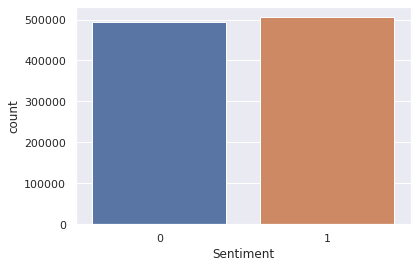

In [11]:
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(x="Sentiment", data=train_df)

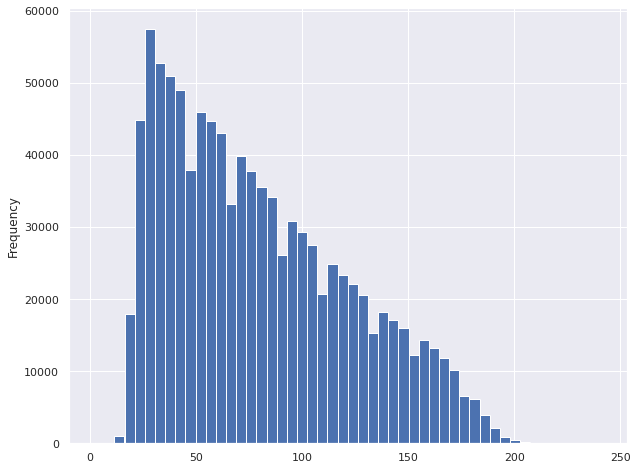

In [12]:
train_df['word_count'].plot(bins=50, kind='hist',figsize = (10,8)) 


# Text Preprocessing

In [13]:
import string 
import re
def remove_punc(s):
    table = str.maketrans({key: None for key in string.punctuation})
    return s.translate(table)
def remove_url(text):
     url=re.compile(r"https?://\S+|www\.\S+")
     return url.sub(r" ",text)

def remove_html(text):
  cleanr = re.compile('<.*?>')
  return cleanr.sub(r" ",text)

def remove_num(text):
   output = re.sub(r'\d+', '', text)
   return output

In [14]:
train_df['Text'] = train_df['Text'].apply(remove_punc)
train_df['Text'] = train_df['Text'].apply(remove_html)
train_df['Text'] = train_df['Text'].apply(remove_url)
train_df['Text'] = train_df['Text'].apply(remove_num)

train_df.shape

(1000000, 3)

In [15]:
train_df.head()

,Text,Sentiment,word_count
0,Stuning even for the nongamer This sound track...,1,80
1,The best soundtrack ever to anything Im readin...,1,97
2,Amazing This soundtrack is my favorite music o...,1,129
3,Excellent Soundtrack I truly like this soundtr...,1,118
4,Remember Pull Your Jaw Off The Floor After Hea...,1,87


In [16]:
len(train_df['word_count'][train_df['word_count']<=25])

63720

In [17]:
train_df1 = train_df[:][train_df['word_count']<=25]
train_df1.head()

,Text,Sentiment,word_count
44,autumn got this for my daughter in NC she is n...,1,22
58,Hunting the Hard Way Thia was a gift for my Hu...,1,25
77,Smells divine This is my second bottle of shee...,1,25
78,Very disappointed This perfume is just AWFUL S...,0,24
99,Caution These tracks are not the original vers...,0,22


In [18]:
train_df1['Sentiment'].value_counts()

1    39932
0    23788
Name: Sentiment, dtype: int64

In [19]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
st_wd = text.ENGLISH_STOP_WORDS
c_vector = CountVectorizer(stop_words = st_wd,min_df=.0001,lowercase=1)
c_vector.fit(train_df1['Text'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=1, max_df=1.0, max_features=None, min_df=0.0001,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [20]:
word_list = list(c_vector.vocabulary_.keys())
stop_words = list(c_vector.stop_words) 

In [21]:
len(stop_words),len(word_list)

(318, 8805)

In [22]:
def remove_words(raw_sen,stop_words):
    sen = [w for w in raw_sen if w not in stop_words]
    return sen

In [23]:
def reviewEdit(raw_sen_list,stop_words):
    sen_list = []
    for i in range(len(raw_sen_list)):
        raw_sen = raw_sen_list[i].split()
        sen_list.append(remove_words(raw_sen,stop_words))
    return sen_list

In [24]:
sen_list = reviewEdit(list(train_df1['Text']),stop_words)

In [25]:
from gensim.models import word2vec
wv_model = word2vec.Word2Vec(sen_list,size=100)

In [26]:
wv_model.wv.syn0.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


(14196, 100)

In [27]:
def fun(sen_list,wv_model):
    word_set = set(wv_model.wv.index2word)
    X = np.zeros([len(sen_list),25,100])
    c = 0
    for sen in sen_list:
        nw=24
        for w in list(reversed(sen)):
            if w in word_set:
                X[c,nw] = wv_model[w]
                nw=nw-1
        c=c+1
    return X

In [28]:
X = fun(sen_list,wv_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [29]:
from sklearn.model_selection import train_test_split
y = train_df1['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.astype('bool')
y_test = y_test.astype('bool')

In [30]:
X_train.shape

(50976, 25, 100)

In [31]:
X

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.2587069 , -0.22786558,  0.06620079, ..., -0.14894865,
         -0.01080521,  0.10984071],
        [ 0.47420582, -0.11915584,  0.01529314, ...,  0.92821705,
         -0.26115036, -0.07370552],
        [ 0.10042459, -0.06854931,  0.01266509, ..., -0.04238864,
          0.01181968,  0.05102717]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.18160158, -0.57144541,  0.28698415, ..., -

In [32]:
np.save("/content/drive/MyDrive/DLA/test_X", X_test, allow_pickle=True, fix_imports=True)
np.save("/content/drive/MyDrive/DLA/y_test", X_test, allow_pickle=True, fix_imports=True)

 # Training

In [33]:
import keras.backend as K
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation,LSTM, SimpleRNN ,GRU , Bidirectional,Input ,Concatenate, Multiply,Lambda,Reshape
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## BDNN LSTM

In [34]:
input_st  = Input(shape=(25,100))
lstm1 = Bidirectional(LSTM(200,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(input_st)
lstm2 = Bidirectional(LSTM(1,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(lstm1)
print(lstm1.shape,' ',lstm2.shape)
lstm2 = Reshape((-1,))(lstm2)
lstm2 = Activation('sigmoid')(lstm2)
lstm2 = Reshape((-1,1))(lstm2)
mult = Multiply()([lstm1,lstm2])

add = Lambda(lambda x: K.sum(x,axis=1))(mult)
dense = Dense(100,activation='relu')(add)
output = Dense(1,activation='sigmoid')(dense)

model = Model(inputs=input_st, outputs=output)
print(model.summary())

(None, 25, 200)   (None, 25, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 100)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 25, 200)      481600      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 25, 1)        1616        bidirectional[0][0]              
__________________________________________________________________________________________________
reshape (Reshape)               (None, 25)           0           bidirectional_1[0][0]            
______________________________________________________________

In [35]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist = model.fit(X_train,y_train,validation_split=0.1,
          epochs=10, batch_size=512)

Epoch 1/10
90/90 [==============================] - 23s 166ms/step - loss: 0.4446 - accuracy: 0.7823 - val_loss: 0.3180 - val_accuracy: 0.8658
Epoch 2/10
90/90 [==============================] - 14s 153ms/step - loss: 0.3074 - accuracy: 0.8701 - val_loss: 0.3005 - val_accuracy: 0.8707
Epoch 3/10
90/90 [==============================] - 14s 152ms/step - loss: 0.2785 - accuracy: 0.8827 - val_loss: 0.2802 - val_accuracy: 0.8786
Epoch 4/10
90/90 [==============================] - 14s 154ms/step - loss: 0.2596 - accuracy: 0.8902 - val_loss: 0.2735 - val_accuracy: 0.8845
Epoch 5/10
90/90 [==============================] - 14s 153ms/step - loss: 0.2490 - accuracy: 0.8935 - val_loss: 0.2729 - val_accuracy: 0.8809
Epoch 6/10
90/90 [==============================] - 14s 154ms/step - loss: 0.2409 - accuracy: 0.8976 - val_loss: 0.2677 - val_accuracy: 0.8851
Epoch 7/10
90/90 [==============================] - 14s 154ms/step - loss: 0.2326 - accuracy: 0.9007 - val_loss: 0.2650 - val_accuracy: 0.8833

In [36]:
y_test = y_test.astype('bool')
model.evaluate(X_test, y_test, batch_size=64)

200/200 [==============================] - 3s 14ms/step - loss: 0.2608 - accuracy: 0.8967


[0.2608293890953064, 0.8967357277870178]

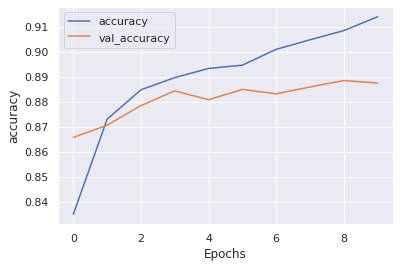

In [37]:
plot_graphs(hist, "accuracy")

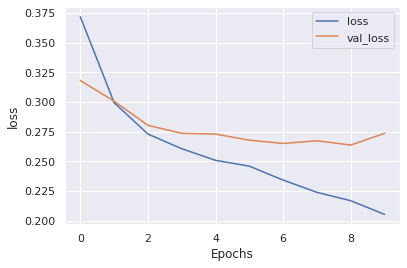

In [38]:
plot_graphs(hist, "loss")

In [39]:
model.save("/content/drive/MyDrive/DLA/BidirectionalLSTM")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DLA/BidirectionalLSTM/assets


In [40]:
del model

##BDNN GRU

In [41]:
input_st  = Input(shape=(25,100))
lstm1 = Bidirectional(GRU(200,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(input_st)
lstm2 = Bidirectional(GRU(1,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(lstm1)
print(lstm1.shape,' ',lstm2.shape)
lstm2 = Reshape((-1,))(lstm2)
lstm2 = Activation('sigmoid')(lstm2)
lstm2 = Reshape((-1,1))(lstm2)
mult = Multiply()([lstm1,lstm2])

add = Lambda(lambda x: K.sum(x,axis=1))(mult)
dense = Dense(100,activation='relu')(add)
output = Dense(1,activation='sigmoid')(dense)

model = Model(inputs=input_st, outputs=output)
print(model.summary())

(None, 25, 200)   (None, 25, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 25, 100)]    0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 25, 200)      362400      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 25, 1)        1218        bidirectional_2[0][0]            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 25)           0           bidirectional_3[0][0]            
____________________________________________________________

In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist = model.fit(X_train,y_train,validation_split=0.1,
          epochs=10, batch_size=512)

Epoch 1/10
90/90 [==============================] - 22s 202ms/step - loss: 0.4385 - accuracy: 0.7666 - val_loss: 0.3117 - val_accuracy: 0.8676
Epoch 2/10
90/90 [==============================] - 17s 192ms/step - loss: 0.2946 - accuracy: 0.8772 - val_loss: 0.2884 - val_accuracy: 0.8784
Epoch 3/10
90/90 [==============================] - 17s 192ms/step - loss: 0.2665 - accuracy: 0.8878 - val_loss: 0.2837 - val_accuracy: 0.8790
Epoch 4/10
90/90 [==============================] - 17s 191ms/step - loss: 0.2531 - accuracy: 0.8910 - val_loss: 0.2762 - val_accuracy: 0.8825
Epoch 5/10
90/90 [==============================] - 17s 194ms/step - loss: 0.2410 - accuracy: 0.9002 - val_loss: 0.2682 - val_accuracy: 0.8874
Epoch 6/10
90/90 [==============================] - 17s 187ms/step - loss: 0.2290 - accuracy: 0.9045 - val_loss: 0.2608 - val_accuracy: 0.8888
Epoch 7/10
90/90 [==============================] - 17s 190ms/step - loss: 0.2167 - accuracy: 0.9118 - val_loss: 0.2621 - val_accuracy: 0.8894

In [43]:
model.evaluate(X_test, y_test, batch_size=64)

200/200 [==============================] - 3s 17ms/step - loss: 0.2598 - accuracy: 0.8978


[0.2598370611667633, 0.8977558016777039]

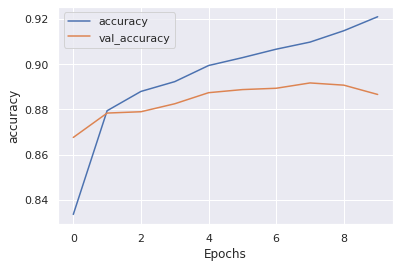

In [44]:
plot_graphs(hist, "accuracy")

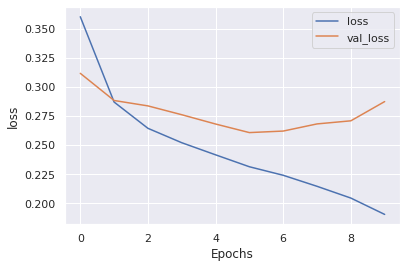

In [45]:
plot_graphs(hist, "loss")

In [46]:
model.save("/content/drive/MyDrive/DLA/BidirectionalGRU")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DLA/BidirectionalGRU/assets


In [47]:
del model